In [1]:
# %pip install albumentations --user

In [2]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:

import torch
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060


In [4]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from PIL import Image

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [5]:
# %pip install segmentation-models-pytorch==0.2.0

In [6]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [7]:
DATA_DIR = 'data'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata_patches.csv'))
# metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
# metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.25, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(48782, 16261)

In [8]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [9]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [10]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [11]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        # image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        image = np.array(Image.open(self.image_paths[i]))
        mask = np.array(Image.open(self.mask_paths[i]))
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

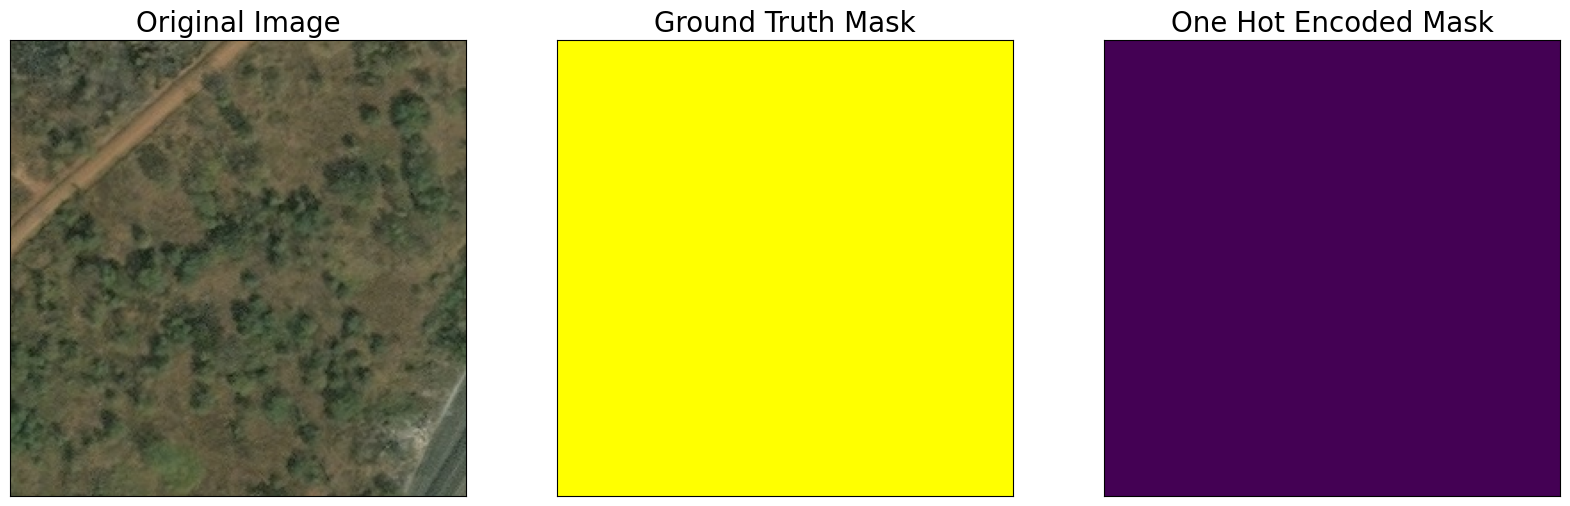

In [12]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [13]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

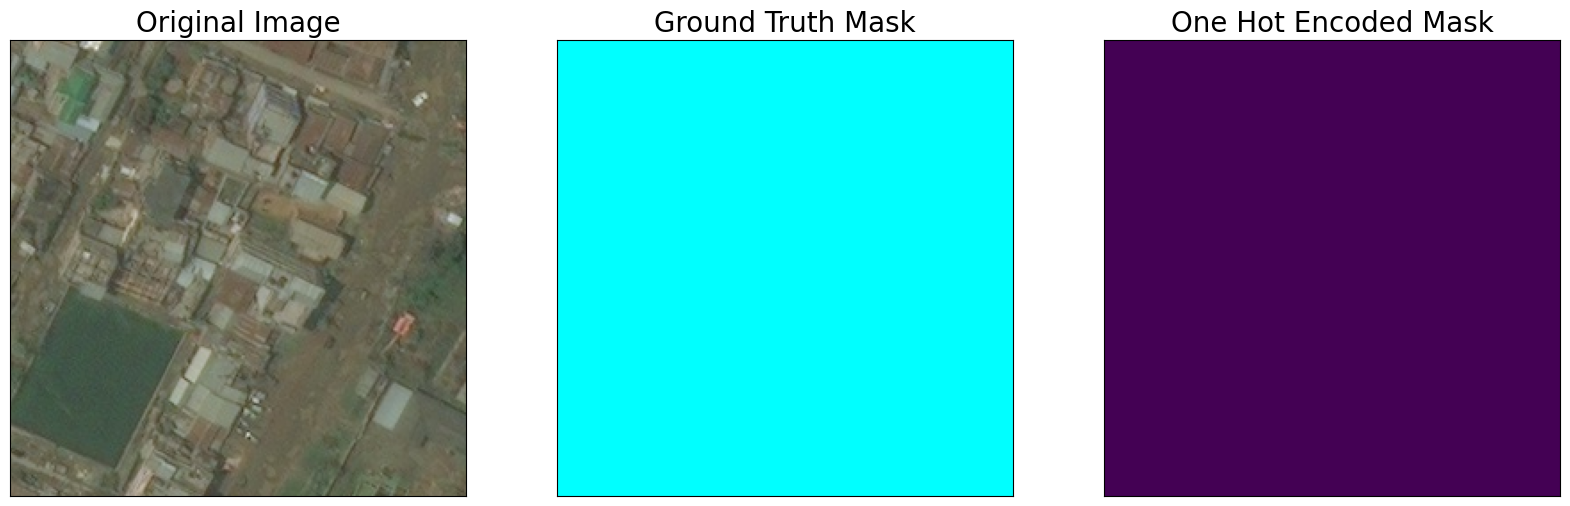

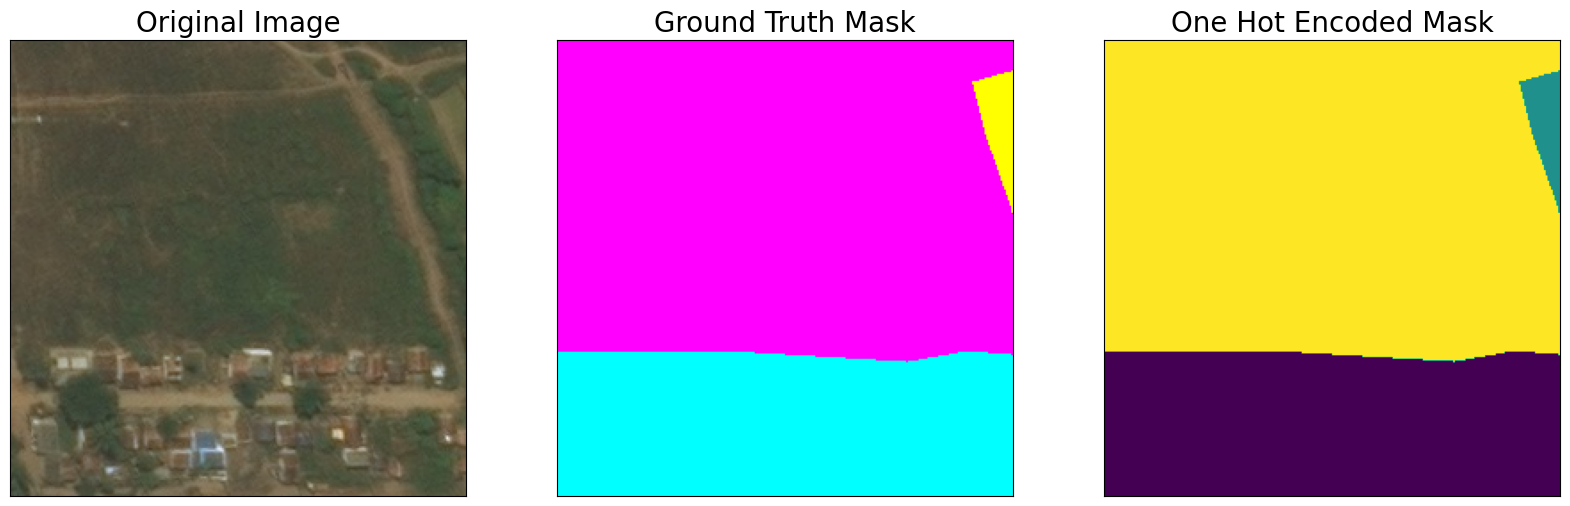

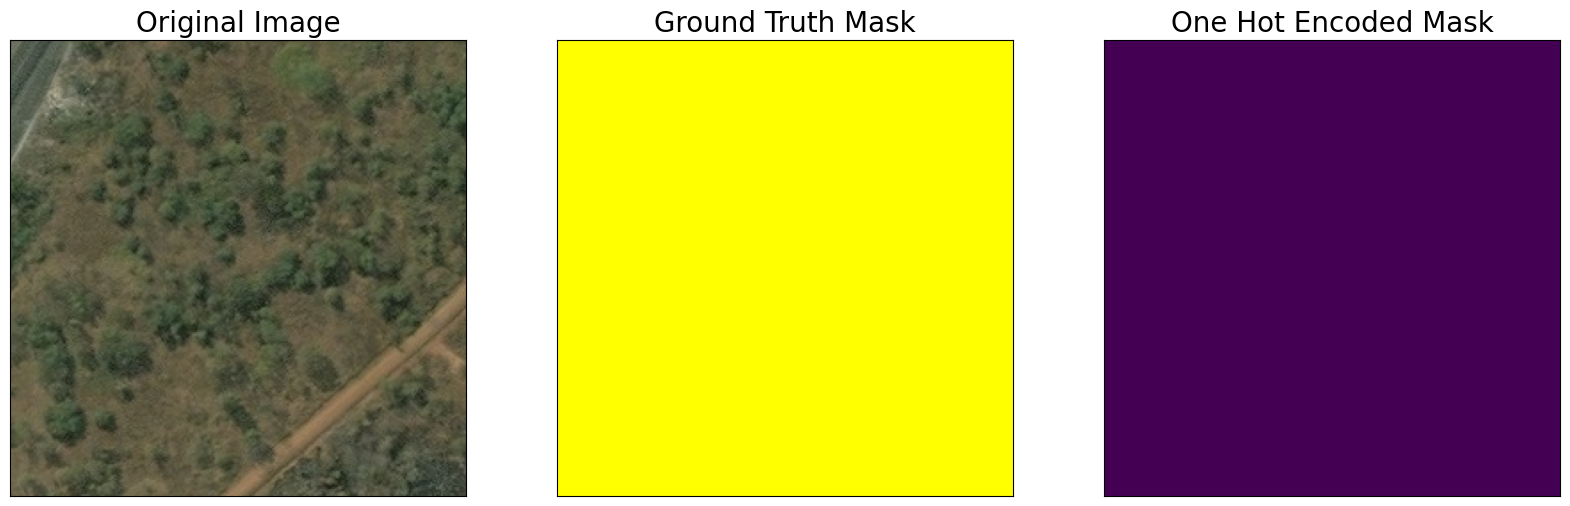

In [14]:
augmented_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [15]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [16]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=0)

In [17]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 30

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('best_model_v4.pth'):
    model = torch.load('best_model_v4.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

In [18]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model_v4.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 1017/1017 [08:22<00:00,  2.02it/s, dice_loss - 0.151, iou_score - 0.7607] 
Model saved!

Epoch: 1
valid: 100%|██████████| 1017/1017 [07:59<00:00,  2.12it/s, dice_loss - 0.1329, iou_score - 0.7749]
Model saved!

Epoch: 2
valid: 100%|██████████| 1017/1017 [07:57<00:00,  2.13it/s, dice_loss - 0.1252, iou_score - 0.7844]
Model saved!

Epoch: 3
valid: 100%|██████████| 1017/1017 [08:00<00:00,  2.12it/s, dice_loss - 0.1195, iou_score - 0.7923]
Model saved!

Epoch: 4
valid: 100%|██████████| 1017/1017 [07:59<00:00,  2.12it/s, dice_loss - 0.1208, iou_score - 0.7906]

Epoch: 5
valid: 100%|██████████| 1017/1017 [07:56<00:00,  2.13it/s, dice_loss - 0.1208, iou_score - 0.79]  

Epoch: 6
valid: 100%|██████████| 1017/1017 [08:02<00:00,  2.11it/s, dice_loss - 0.1189, iou_score - 0.7929]
Model saved!

Epoch: 7
valid: 100%|██████████| 1017/1017 [08:05<00:00,  2.10it/s, dice_loss - 0.1133, iou_score - 0.8016]
Model saved!

Epoch: 8
valid: 100%|██████████| 1017/1017 [08:08

In [20]:
import os
import torch
# DEVICE = CUDA
# load best saved model checkpoint from the current run
if os.path.exists('best_model_v4.pth'):
    best_model = torch.load('best_model_v4.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')


Loaded DeepLabV3+ model from this run.


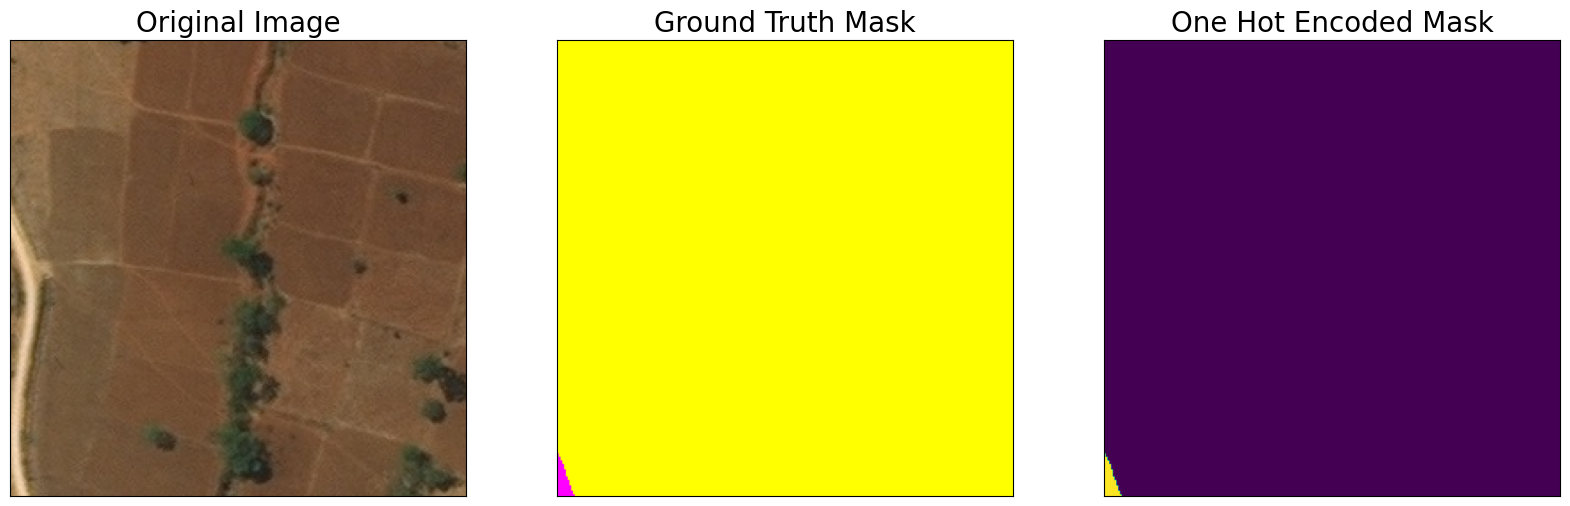

In [21]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [22]:
sample_preds_folder = 'data/sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [23]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

In [24]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 16261/16261 [11:23<00:00, 23.79it/s, dice_loss - 0.111, iou_score - 0.848]  
Evaluation on Test Data: 
Mean IoU Score: 0.8480
Mean Dice Loss: 0.1110


In [25]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
dice_loss,0.279238,0.161158,0.139254,0.130942,0.123335,0.119031,0.115667,0.111357,0.108892,0.105364,...,0.086053,0.083607,0.082264,0.081141,0.080328,0.078931,0.077340,0.076549,0.074667,0.075017
iou_score,0.650198,0.747626,0.769043,0.778688,0.788628,0.794820,0.799576,0.805872,0.809600,0.815007,...,0.845750,0.849710,0.851941,0.853753,0.855124,0.857486,0.860196,0.861488,0.864422,0.864053


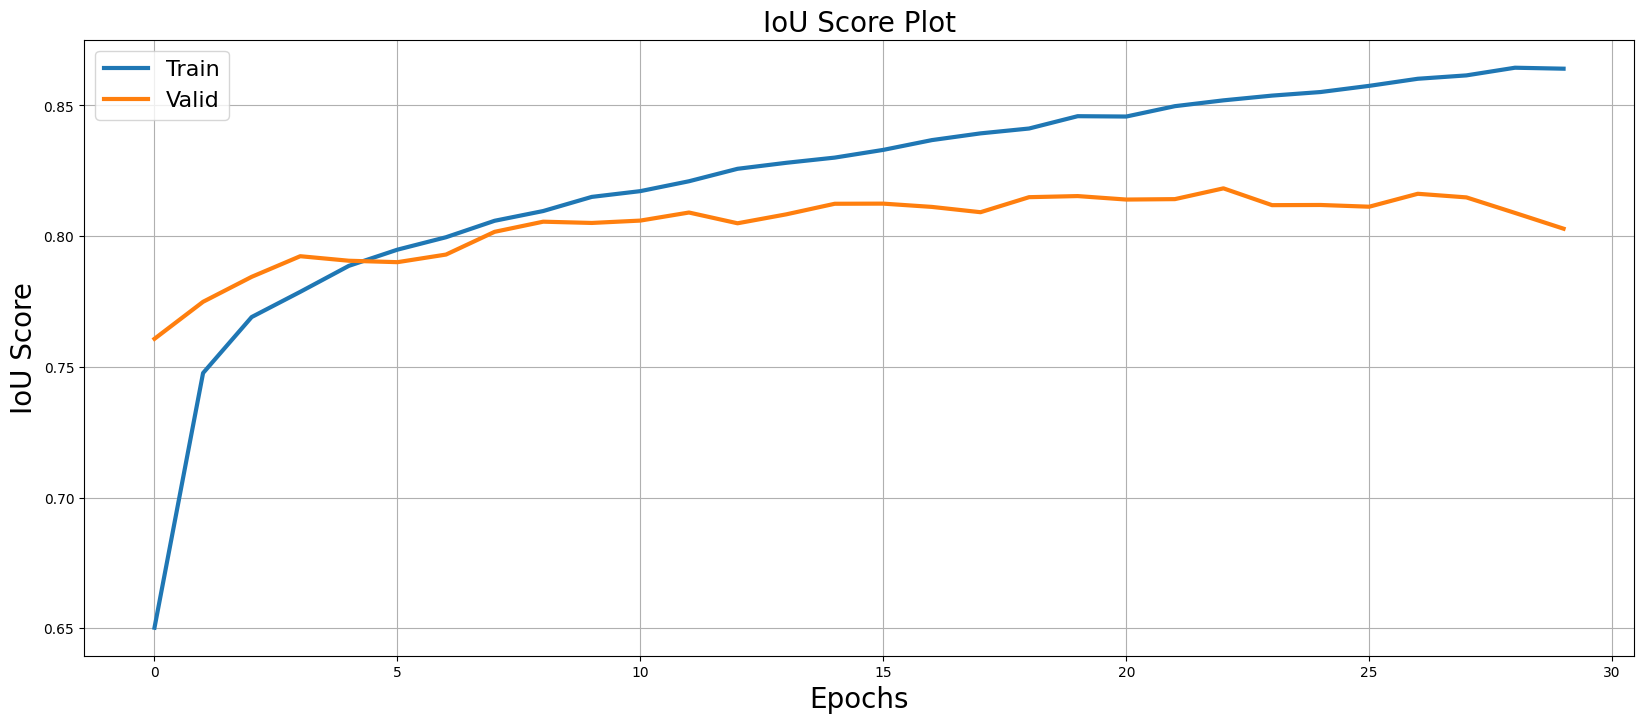

In [26]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

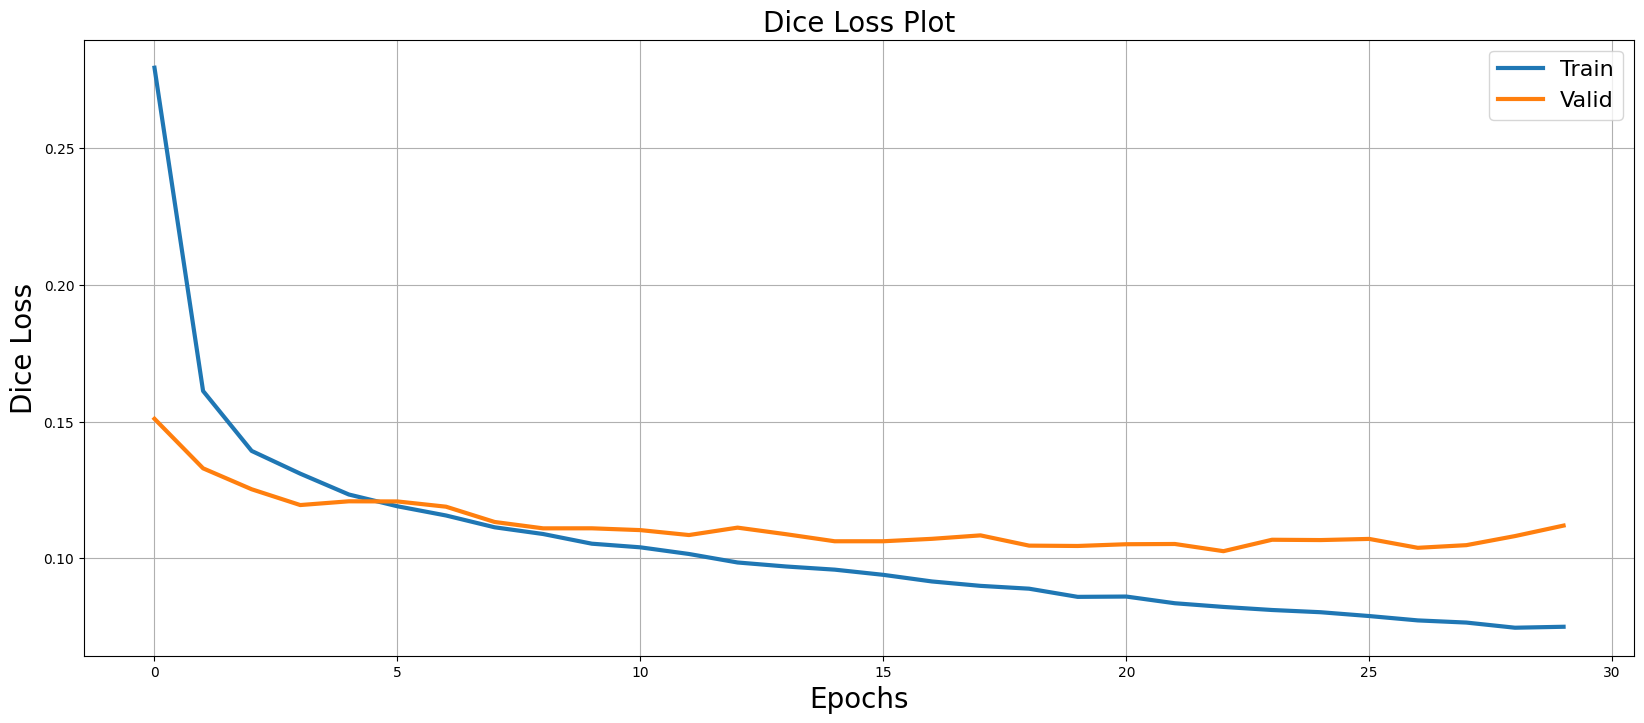

In [27]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

TESTE COM TILES

In [28]:
temp_img = cv2.imread('data/tiles/46413_77757_17.jpg')
print(temp_img.shape)

(256, 256, 3)


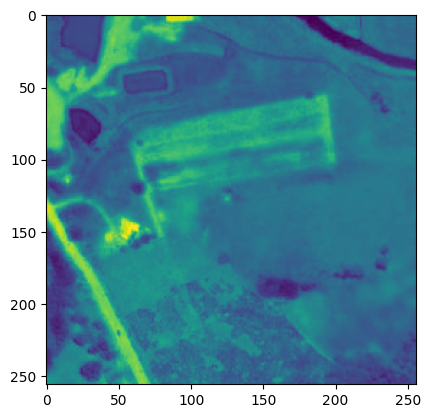

In [29]:
plt.imshow(temp_img[:,:,2])

In [30]:
import os
import torch
# DEVICE = CUDA
# load best saved model checkpoint from the current run
if os.path.exists('best_model_v4.pth'):
    best_model = torch.load('best_model_v4.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

Loaded DeepLabV3+ model from this run.


In [31]:
sample_preds_folder = 'data/tiles_prediction/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [32]:
tiles_folder = 'data/tiles/'

# Get all tile images
tile_images = [os.path.join(tiles_folder, img) for img in os.listdir(tiles_folder) if img.endswith('.jpg')]

for idx, tile_img in enumerate(tile_images):
  print(f"Processing tile: {tile_img}")
  image = np.array(Image.open(tile_img))
  image = preprocessing_fn(image)
  x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0).float()
  x_tensor = x_tensor.permute(0,3,1,2)
  # Predict test image
  pred_mask = best_model(x_tensor)
  pred_mask = pred_mask.detach().squeeze().cpu().numpy()
  # Convert pred_mask from `CHW` format to `HWC` format
  pred_mask = np.transpose(pred_mask,(1,2,0))
  # Get prediction channel corresponding to foreground
  pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
  cv2.imwrite(os.path.join(sample_preds_folder, f"tile_pred_{idx}.png"), np.hstack([pred_mask])[:,:,::-1])
    

Processing tile: data/tiles/46413_77757_17.jpg
Processing tile: data/tiles/46413_77758_17.jpg
Processing tile: data/tiles/46413_77759_17.jpg
Processing tile: data/tiles/46413_77760_17.jpg
Processing tile: data/tiles/46414_77757_17.jpg
Processing tile: data/tiles/46414_77758_17.jpg
Processing tile: data/tiles/46414_77759_17.jpg
Processing tile: data/tiles/46414_77760_17.jpg
Processing tile: data/tiles/46415_77757_17.jpg
Processing tile: data/tiles/46415_77758_17.jpg
Processing tile: data/tiles/46415_77759_17.jpg
Processing tile: data/tiles/46415_77760_17.jpg
Processing tile: data/tiles/46416_77757_17.jpg
Processing tile: data/tiles/46416_77758_17.jpg
Processing tile: data/tiles/46416_77759_17.jpg
Processing tile: data/tiles/46416_77760_17.jpg
Processing tile: data/tiles/46417_77757_17.jpg
Processing tile: data/tiles/46417_77758_17.jpg
Processing tile: data/tiles/46417_77759_17.jpg
Processing tile: data/tiles/46417_77760_17.jpg
Processing tile: data/tiles/46418_77757_17.jpg
Processing ti

In [33]:
input_image = 'tcc_image.jfif'
patch_size = 256
n_classes = 7

In [34]:
###################################################################################
#Predict using smooth blending

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
from smooth_tiled_predictions import predict_img_with_smooth_windowing
image = np.array(Image.open(input_image))  #N-34-66-C-c-4-3.tif, N-34-97-D-c-2-4.tif
image = preprocessing_fn(image)

input_image = image

def predict_mask(img_batch_subdiv):
    img_batch_subdiv = torch.from_numpy(img_batch_subdiv).to(DEVICE).float()
    img_batch_subdiv = img_batch_subdiv.permute(0,3,1,2)
    img_batch_subdiv = best_model(img_batch_subdiv)
    img_batch_subdiv = img_batch_subdiv.detach().squeeze().cpu().numpy()
    print(img_batch_subdiv.shape) #(55, 7, 256, 256)
    # Convert pred_mask from `CHW` format to `HWC` format
    img_batch_subdiv = np.transpose(img_batch_subdiv,(0,2,3,1))
    
    return  img_batch_subdiv

predictions_smooth = predict_img_with_smooth_windowing(
    input_image,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: predict_mask((img_batch_subdiv))
    )
)

  0%|          | 0/8 [00:00<?, ?it/s]

(55, 7, 256, 256)


 12%|█▎        | 1/8 [00:08<01:00,  8.59s/it]

(55, 7, 256, 256)


 25%|██▌       | 2/8 [00:24<01:18, 13.12s/it]

(55, 7, 256, 256)


 38%|███▊      | 3/8 [00:41<01:12, 14.58s/it]

(55, 7, 256, 256)


 50%|█████     | 4/8 [00:57<01:01, 15.26s/it]

(55, 7, 256, 256)


 62%|██████▎   | 5/8 [01:13<00:46, 15.63s/it]

(55, 7, 256, 256)


 75%|███████▌  | 6/8 [01:30<00:31, 15.87s/it]

(55, 7, 256, 256)


 88%|████████▊ | 7/8 [01:46<00:16, 16.01s/it]

(55, 7, 256, 256)


100%|██████████| 8/8 [02:02<00:00, 15.34s/it]


In [35]:
final_prediction = np.argmax(predictions_smooth, axis=2)

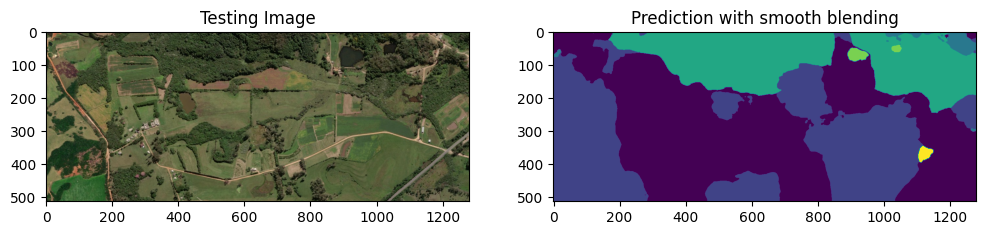

In [36]:
#Save prediction and original mask for comparison
plt.imsave('pred_segmented_deepglobe_v4.png', final_prediction)
# plt.imsave('test_deepglobe/N-34-66-C-c-4-3.tif_mask.jpg', original_mask)
###################
input_image = 'tcc_image.jfif'
image = Image.open(input_image)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(image)
plt.subplot(222)
# plt.title('Testing Label')
# plt.imshow(original_mask)
# plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()